# Задание 1: Стандартные аугментации torchvision (15 баллов)
<br>1.Создайте пайплайн стандартных аугментаций torchvision (например, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomRotation, RandomGrayscale).<br>
<br>2.Примените аугментации к 5 изображениям из разных классов (папка train).<br>
3.Визуализируйте:
 <br>-Оригинал<br>
 <br>-Результат применения каждой аугментации отдельно<br>
 <br>-Результат применения всех аугментаций вместе<br>

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image


def show_multiple_augmentations(original_img, augmented_imgs, titles):
    """Визуализирует оригинальное изображение и несколько аугментаций."""
    n_augs = len(augmented_imgs)
    fig, axes = plt.subplots(1, n_augs + 1, figsize=((n_augs + 1) * 2, 2))
    
    # Инициализация преобразований
    to_tensor = transforms.ToTensor()
    resize_transform = transforms.Resize((128, 128), antialias=True)
    
    # Универсальная обработка оригинального изображения
    if isinstance(original_img, torch.Tensor):
        orig_tensor = original_img
    else:
        orig_tensor = to_tensor(original_img)
        
    orig_resized = resize_transform(orig_tensor)
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    axes[0].imshow(orig_np)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')
    
    # Обработка аугментированных изображений
    for i, (aug_img, title) in enumerate(zip(augmented_imgs, titles)):
        # Преобразуем в тензор, если нужно
        if isinstance(aug_img, torch.Tensor):
            aug_tensor = aug_img
        else:
            aug_tensor = to_tensor(aug_img)
            
        aug_resized = resize_transform(aug_tensor)
        aug_np = aug_resized.numpy().transpose(1, 2, 0)
        aug_np = np.clip(aug_np, 0, 1)
        axes[i + 1].imshow(aug_np)
        axes[i + 1].set_title(title)
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from datasets import CustomImageDataset
from utils import show_images, show_single_augmentation
from extra_augs import (AddGaussianNoise, RandomErasingCustom, CutOut, 
                       Solarize, Posterize, AutoContrast, ElasticTransform)


root = './different_classes/train'
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))



In [45]:
original_img, label = dataset[0]
class_names = dataset.get_class_names()
print(f"Оригинальное изображение, класс: {class_names[label]}")

Оригинальное изображение, класс: Гароу


применение аугментаций отдельно


=== Стандартные аугментации torchvision ===


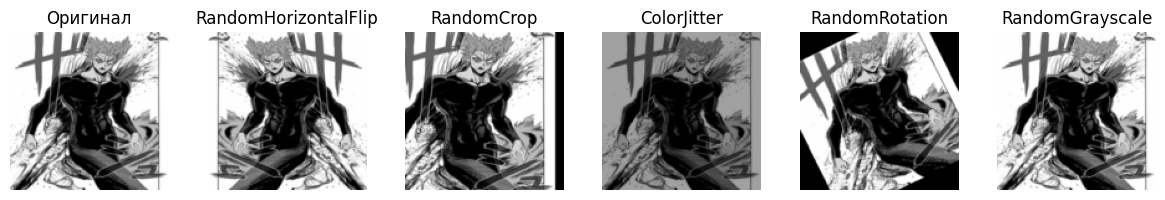

In [61]:
print("\n=== Стандартные аугментации torchvision ===")

standard_augs = [
    ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=1.0)),
    ("RandomCrop", transforms.RandomCrop(200, padding=20)),
    ("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
    ("RandomRotation", transforms.RandomRotation(degrees=30)),
    ("RandomGrayscale", transforms.RandomGrayscale(p=1.0))
]

augmented_imgs = []
titles = []

for name, aug in standard_augs:
    aug_transform = transforms.Compose([
        aug,
        transforms.ToTensor()
    ])
    aug_img = aug_transform(original_img)
    augmented_imgs.append(aug_img)
    titles.append(name)

show_multiple_augmentations(original_img, augmented_imgs, titles)


Применение аугментаций вместе



=== Комбинированные аугментации ===


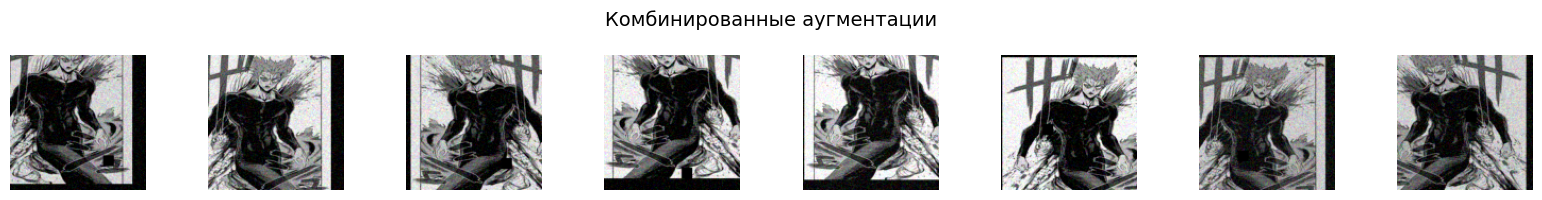

In [47]:
print("\n=== Комбинированные аугментации ===")

combined_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(200, padding=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1),
    CutOut(p=0.5)
])

combined_imgs = []
for i in range(8):
    combined_img = combined_aug(original_img)
    combined_imgs.append(combined_img)

show_images(combined_imgs, title="Комбинированные аугментации") 

# Задание 2: Кастомные аугментации (20 баллов)
<br>Реализуйте минимум 3 кастомные аугментации (например, случайное размытие, случайная перспектива, случайная яркость/контрастность).
Примените их к изображениям из train.
Сравните визуально с готовыми аугментациями из extra_augs.py.

In [79]:
import random
import torch
import torchvision.transforms.functional as F
from torchvision.transforms.functional import perspective
from PIL import Image

class GaussianBlur:
    """Применяет гауссово размытие с случайными параметрами."""
    def __init__(self, p=0.5, kernel_size=(3, 7), sigma=(0.1, 2.0)):
        self.p = p
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        if random.random() > self.p:
            return img
        
        # Генерация случайных параметров
        kernel_size = random.choice(range(self.kernel_size[0], self.kernel_size[1] + 1, 2))
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        
        # Работает как с PIL, так и с тензорами
        return F.gaussian_blur(img, kernel_size, sigma)


class RandomPerspective:
    """Применяет случайное перспективное искажение."""
    def __init__(self, p=0.5, distortion_scale=0.5):
        self.p = p
        self.distortion_scale = distortion_scale

    def __call__(self, img):
        if random.random() > self.p:
            return img
        
        # Получаем размеры в зависимости от типа
        if isinstance(img, torch.Tensor):
            _, h, w = img.shape
        else:  # PIL Image
            w, h = img.size
        
        startpoints = [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]]
        
        # Генерация случайных конечных точек
        endpoints = []
        for x, y in startpoints:
            dx = random.randint(-int(w * self.distortion_scale), int(w * self.distortion_scale))
            dy = random.randint(-int(h * self.distortion_scale), int(h * self.distortion_scale))
            endpoints.append([x + dx, y + dy])
            
        return perspective(img, startpoints, endpoints)


class RandomContrast:
    """Случайно изменяет контраст изображения."""
    def __init__(self, p=0.5, factor=(0.7, 1.3)):
        self.p = p
        self.factor = factor

    def __call__(self, img):
        if random.random() > self.p:
            return img
            
        contrast_factor = random.uniform(self.factor[0], self.factor[1])
        return F.adjust_contrast(img, contrast_factor)

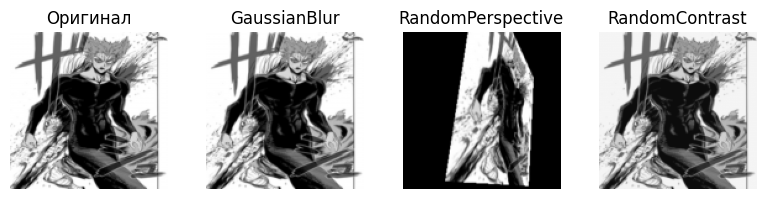

In [86]:
# Создание аугментаций
augmentations = [
    ("GaussianBlur", GaussianBlur(p=1.0)),
    ("RandomPerspective", RandomPerspective(p=1.0)),
    ("RandomContrast", RandomContrast(p=1.0))
]

# Применение к изображению
augmented_imgs = []
titles = []

for name, aug in augmentations:
    aug_img = aug(original_img)  # original_tensor: torch.Tensor [C, H, W]
    augmented_imgs.append(aug_img)
    titles.append(name)

# Визуализация (используйте вашу исправленную функцию)
show_multiple_augmentations(original_img, augmented_imgs, titles)

# Задание 3: Анализ датасета (10 баллов)
<br>1.Подсчитайте количество изображений в каждом классе.<br>
<br>2.Найдите минимальный, максимальный и средний размеры изображений.<br>
<br>3.Визуализируйте распределение размеров и гистограмму по классам.<br>

In [87]:
import os
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt

def count_images_per_class(dataset_path='dataset/train'):
    """
    Подсчитывает количество изображений в каждом классе датасета.
    
    Args:
        dataset_path (str): Путь к директории с тренировочными данными
        
    Returns:
        dict: Словарь с количеством изображений для каждого класса
    """
    # Создаем словарь для хранения результатов
    class_counts = defaultdict(int)
    
    # Проверяем существование директории
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Директория {dataset_path} не существует!")
    
    # Получаем список всех классов (поддиректорий)
    classes = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d))]
    
    # Если классов не найдено
    if not classes:
        print(f"В директории {dataset_path} не найдено поддиректорий с классами!")
        return {}
    
    # Перебираем все классы
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        
        # Подсчитываем файлы в директории класса
        # Фильтруем только изображения по расширениям
        image_count = 0
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_count += 1
                
        class_counts[class_name] = image_count
    
    return dict(class_counts)

def visualize_class_counts(class_counts):
    """
    Визуализирует распределение изображений по классам.
    
    Args:
        class_counts (dict): Словарь с количеством изображений по классам
    """
    if not class_counts:
        print("Нет данных для визуализации!")
        return
        
    # Сортируем классы по количеству изображений
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    class_names, counts = zip(*sorted_classes)
    
    # Создаем график
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    plt.bar(class_names, counts, color='skyblue')
    plt.title('Количество изображений по классам')
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.xticks(rotation=45, ha='right')
    
    # Круговая диаграмма
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Распределение изображений')
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

In [88]:
count_images_on_dataset =count_images_per_class()
count_images_on_dataset

{'Гароу': 29,
 'Генос': 29,
 'Сайтама': 29,
 'Соник': 29,
 'Татсумаки': 29,
 'Фубуки': 29}

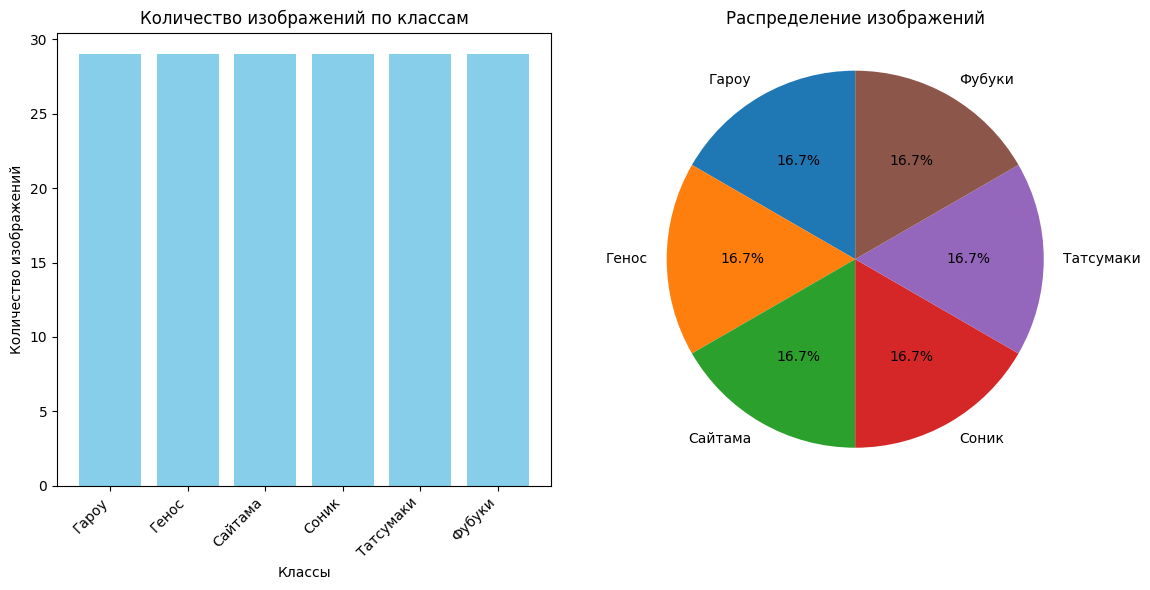

In [89]:
visualize_class_counts(count_images_on_dataset)

как видим классы хорошо сбалансированы

# Задание 4: Pipeline аугментаций (20 баллов)

<br>1.Реализуйте класс AugmentationPipeline с методами:<br>
- add_augmentation(name, aug)
- remove_augmentation(name)
- apply(image)
- get_augmentations()
<br>2.Создайте несколько конфигураций (light, medium, heavy).<br>
<br>3.Примените каждую конфигурацию к train и сохраните результаты.<br>

In [105]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentation = []
       
    def add_augmentations(self,name,aug):
        self.augmentation.append((name,aug))
    
    def remove_augmentation(self,name):
        for i in range(len(self.augmentation)):
            if self.augmentation[i][0] == name:
                del self.augmentation[i]
    
    def apply(self,image):
        augmentation_image = []
        for name, aug in self.augmentation:
            aug_img = aug(image)  # original_tensor: torch.Tensor [C, H, W]
            augmentation_image.append(aug_img)
        return augmentation_image
        
    def get_augmentations(self):
        return self.augmentation

In [ ]:
augment = AugmentationPipeline()

In [117]:
from pathlib import Path
import os
from PIL import Image
from tqdm import tqdm

def apply_augmentations_to_dataset(input_dir='dataset/train',
                                  output_dir='results/train',
                                  augmentations_class=None):
    """
    Применяет аугментации ко всем изображениям в датасете и сохраняет результаты.
    
    Args:
        input_dir (str): Путь к исходной папке с данными
        output_dir (str): Путь для сохранения аугментированных данных
        augmentations_class (AugmentationPipeline): Объект с аугментациями для применения
    """
    
    # Создаем выходную директорию
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Получаем список классов
    classes = [d for d in os.listdir(input_dir) 
               if os.path.isdir(os.path.join(input_dir, d))]
    
    if not classes:
        print(f"В директории {input_dir} не найдено классов!")
        return
    
    # Обрабатываем каждый класс
    for class_name in tqdm(classes, desc="Обработка классов"):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        
        # Создаем директорию для класса
        Path(class_output_dir).mkdir(parents=True, exist_ok=True)
        
        # Получаем список изображений
        image_files = [f for f in os.listdir(class_input_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        # Обрабатываем каждое изображение
        for image_file in tqdm(image_files, desc=f"Класс {class_name}", leave=False):
            image_path = os.path.join(class_input_dir, image_file)
            
            try:
                # Загружаем изображение
                img = Image.open(image_path)
                
                # Генерируем базовое имя файла (без расширения)
                base_name = os.path.splitext(image_file)[0]
                ext = os.path.splitext(image_file)[1].lower()
                
                # Применяем аугментации
                augmented_images = augmentations_class.apply(img)
                augmentation_names = augmentations_class.get_augmentations()

                # Сохраняем каждое аугментированное изображение
                for idx, aug_img in enumerate(augmented_images):
                    output_filename = f"{base_name}_aug{augmentation_names[idx][0]}{ext}"
                    output_path = os.path.join(class_output_dir, output_filename)
                    
                    # Сохраняем изображение
                    aug_img.save(output_path)
                
            except Exception as e:
                print(f"\nОшибка при обработке {image_path}: {e}")
                continue

In [114]:
aug_light = AugmentationPipeline()#3 аугментации
aug_medium = AugmentationPipeline()#6
aug_heavy = AugmentationPipeline()#8



aug_light.add_augmentations("GaussianBlur", GaussianBlur(p=1.0))
aug_light.add_augmentations("RandomPerspective", RandomPerspective(p=1.0))
aug_light.add_augmentations("RandomContrast", RandomContrast(p=1.0))

aug_medium.add_augmentations("GaussianBlur", GaussianBlur(p=1.0))
aug_medium.add_augmentations("RandomPerspective", RandomPerspective(p=1.0))
aug_medium.add_augmentations("RandomContrast", RandomContrast(p=1.0))
aug_medium.add_augmentations("RandomHorizontalFlip",  transforms.RandomHorizontalFlip(p=0.5))
aug_medium.add_augmentations("RandomCrop",transforms.RandomCrop(200, padding=20))
aug_medium.add_augmentations("ColorJitter", transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))


aug_heavy.add_augmentations("GaussianBlur", GaussianBlur(p=1.0))
aug_heavy.add_augmentations("RandomPerspective", RandomPerspective(p=1.0))
aug_heavy.add_augmentations("RandomContrast", RandomContrast(p=1.0))
aug_heavy.add_augmentations("RandomHorizontalFlip",  transforms.RandomHorizontalFlip(p=0.5))
aug_heavy.add_augmentations("RandomCrop",transforms.RandomCrop(200, padding=20))
aug_heavy.add_augmentations("ColorJitter", transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))
aug_heavy.add_augmentations("RandomRotation",  transforms.RandomRotation(degrees=30))
aug_heavy.add_augmentations("RandomGrayscale", transforms.RandomGrayscale(p=1.0))


In [119]:
apply_augmentations_to_dataset(augmentations_class =aug_light,output_dir='results/light/train')

Обработка классов: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


In [121]:
apply_augmentations_to_dataset(augmentations_class =aug_medium,output_dir='results/medium/train')

Обработка классов: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


In [122]:
apply_augmentations_to_dataset(augmentations_class =aug_heavy,output_dir='results/heavy/train')

Обработка классов: 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


# Задание 6: Дообучение предобученных моделей (25 баллов)

Возьмите одну из предобученных моделей torchvision (например, resnet18, efficientnet_b0, mobilenet_v3_small).
- Замените последний слой на количество классов вашего датасета.
- Дообучите модель на train, проверьте качество на val.
- Визуализируйте процесс обучения (loss/accuracy).

In [126]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import CustomImageDataset
import matplotlib.pyplot as plt

# Подготовка датасета
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = CustomImageDataset('dataset/train', transform=transform)
val_dataset = CustomImageDataset('dataset/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Загрузка предобученной модели
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.get_class_names()))

# Обучение
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

arr_val_accuracy = []
arr_val_loss = []
for epoch in range(3):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)  # Предполагается, что y уже в формате torch.long
        loss.backward()
        optimizer.step()

    # Валидация
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            # Убедитесь, что данные в правильном формате
            data = data.to(dtype=torch.float32)
            target = target.to(dtype=torch.long)  # Метки должны быть torch.long
            output = model(data)
            loss = loss_fn(output, target)  # Убрано view(-1, 1)
            val_loss += loss.item()

            # Вычисляем точность для многоклассовой классификации
            _, preds = torch.max(output, 1)  # Берем индекс максимального логита
            val_correct += (preds == target).sum().item()
            val_total += target.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    arr_val_accuracy.append(val_accuracy)
    arr_val_loss.append(avg_val_loss)
    print(f'Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Визуализация
plt.plot(arr_val_accuracy, label='Val Accuracy')
plt.plot(arr_val_loss, label='Val Loss')
plt.title("ResNet18 Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc='upper left')
plt.savefig('plots/resnet18.png')
plt.close()

Epoch 1, Val Loss: 2.1242, Val Accuracy: 0.6217
Epoch 2, Val Loss: 4.9537, Val Accuracy: 0.4683
Epoch 3, Val Loss: 4.9041, Val Accuracy: 0.4283
